Fine-tune a pretrained GPT-2 model on the OpenTriviaQA: https://github.com/uberspot/OpenTriviaQA/ ([CC-BY-SA-4.0 license](https://github.com/uberspot/OpenTriviaQA/blob/master/LICENSE))

We'll try to remove the train-validation overfit of the opentrivia_small notebook by increasing dropout: model.dropout=0.2.

The dataset was prepared by downloading the dataset and running the prepare_OpenTriviaQA.py script in ../dataprep/

```
python prepare_OpenTriviaQA.py --shuffle --split=0.9 ..\..\..\datasets\text\en\OpenTriviaQA-master\categories OpenTriviaQA.txt
Slurping animals
Slurping brain-teasers
Slurping celebrities
Slurping entertainment
Slurping for-kids
Slurping general
Slurping geography
Slurping history
Slurping hobbies
Slurping humanities
Slurping literature
Slurping movies
Slurping music
Slurping newest
Slurping people
Slurping rated
Slurping religion-faith
Slurping science-technology
Slurping sports
Slurping television
Slurping video-games
Slurping world
QAs mid-count: 34361
Matching entries count: 34353
Entries - split_index: 30917 of 34353
OpenTriviaQA.train.txt: len=3671591
OpenTriviaQA.val.txt: len=408887
```
A train/validation split was cut at 90%.

The script creates entries in the form:

```
Q: What essential vitamin is supplied through the consumption of carrots?
A: Vitamin A<|endoftext|>
Q: Name the Titan who stole fire from Zeus and gave it to mortals.
A: Prometheus<|endoftext|>
Q: What object did Isaac Newton use to demonstrate the decomposition of white light into a color spectrum?
A: Prism<|endoftext|>
```
(Newlines after <|endoftext|> were added above for readability.)

At inference time, we'll pass the question (or a similar text) until A: as the start_text.

In [1]:
from gptbench import Train, empty_config

In [2]:
ben = Train('opentrivia-gpt2-drop=0.2', seed=0xC0B01C0B)

cfg = empty_config()

cfg.model.set(dtype='bfloat16', dropout=0.2)

# we're doing gradient accummulation to use a batch_size of 16 while accumulating batches of 4 entries (trainer.accum_size setting)
# if you get an out of memory error, lower the accum_size:
cfg.trainer.set(learning_rate=1e-4, batch_size=16, accum_size=4)
#cfg.trainer.set(learning_rate=1e-3, batch_size=3)

cfg.train.set(eval_period=200, eval_iters=50)

cfg.sample.set(eot_stop=-1, start_text='Q:')

#ben.init_pretrained('gpt2', cfg)

force_new = False
if ben.can_load() and not force_new:
    ben.load(cfg)
else:
    ben.init_pretrained('gpt2', cfg)    

Loading checkpoint from ./checkpoints/opentrivia-gpt2-drop=0.2/
Dataset: encoding utf-8 to tokens
Dataset: loading uint16 tokens
Dataset: encoding utf-8 to tokens
Checkpoint: iter=2600 (0.048 epoch), loss train=2.5956 val=2.7597 eval->2.7597
Dataset train_path: ../data/OpenTriviaQA/OpenTriviaQA.train.txt, val_path: ../data/OpenTriviaQA/OpenTriviaQA.val.txt, train_split: None, vocab_size: 50257
Model params: 124.44M


In [4]:
# the model was loaded above using a dummy dataset, because we didn't provide one - set the ARC data:
# train_split=1 means no validation dataset, to maximize training data
ben.set_datasets(class_name='gpt2', # GPT2TokensDataset class
                 train_path='../data/OpenTriviaQA/OpenTriviaQA.train.txt', 
                 val_path='../data/OpenTriviaQA/OpenTriviaQA.val.txt') 

# set training log periods to avoid cluttering the training output
ben.set_train_log_periods(sample_period=250, dot_period=1, loss_period=50)

In [5]:
# and train for n iters
ben.train(iter_count=1000)

Dataset: encoding utf-8 to tokens
Dataset: loading uint16 tokens
Dataset: encoding utf-8 to tokens
Training
.Iter 1 (0.000 epoch): loss train=3.8888, val=3.8797, eval->3.8797
==> Saving model at iter=1, eval loss->3.8797 
.................................................
Iter 50 loss=3.5391, iter_dt=958.20ms
..................................................
Iter 100 loss=3.3398, iter_dt=960.87ms
..................................................
Iter 150 loss=3.3281, iter_dt=937.46ms
..................................................
Iter 200 (0.004 epoch): loss train=2.9256, val=2.9344, eval->2.9344
==> Saving model at iter=200, eval loss->2.9344 
..................................................
Iter 250 loss=3.1953, iter_dt=940.08ms
Sampling: Q: What did Josh Gordon leadensters in in so much drama Last Call 2009?
A: Rubén Shipens
..................................................
Iter 300 loss=3.1914, iter_dt=940.01ms
..................................................
Iter 350 los

In [6]:
# and train for n iters
ben.train(iter_count=2000)

Training
..................................................
Iter 1050 loss=2.9570, iter_dt=1011.43ms
..................................................
Iter 1100 loss=2.9844, iter_dt=996.06ms
..................................................
Iter 1150 loss=2.9648, iter_dt=936.48ms
..................................................
Iter 1200 (0.022 epoch): loss train=2.7044, val=2.8069, eval->2.8069
==> Saving model at iter=1200, eval loss->2.8069 
..................................................
Iter 1250 loss=2.9688, iter_dt=966.54ms
Sampling: Q: Chinese cooking is quite unusual in Zhou speaking. Why?
A: We only eat forbidden meats
..................................................
Iter 1300 loss=2.9531, iter_dt=933.05ms
..................................................
Iter 1350 loss=2.9570, iter_dt=939.05ms
..................................................
Iter 1400 (0.026 epoch): loss train=2.6684, val=2.7984, eval->2.7984
==> Saving model at iter=1400, eval loss->2.7984 
....

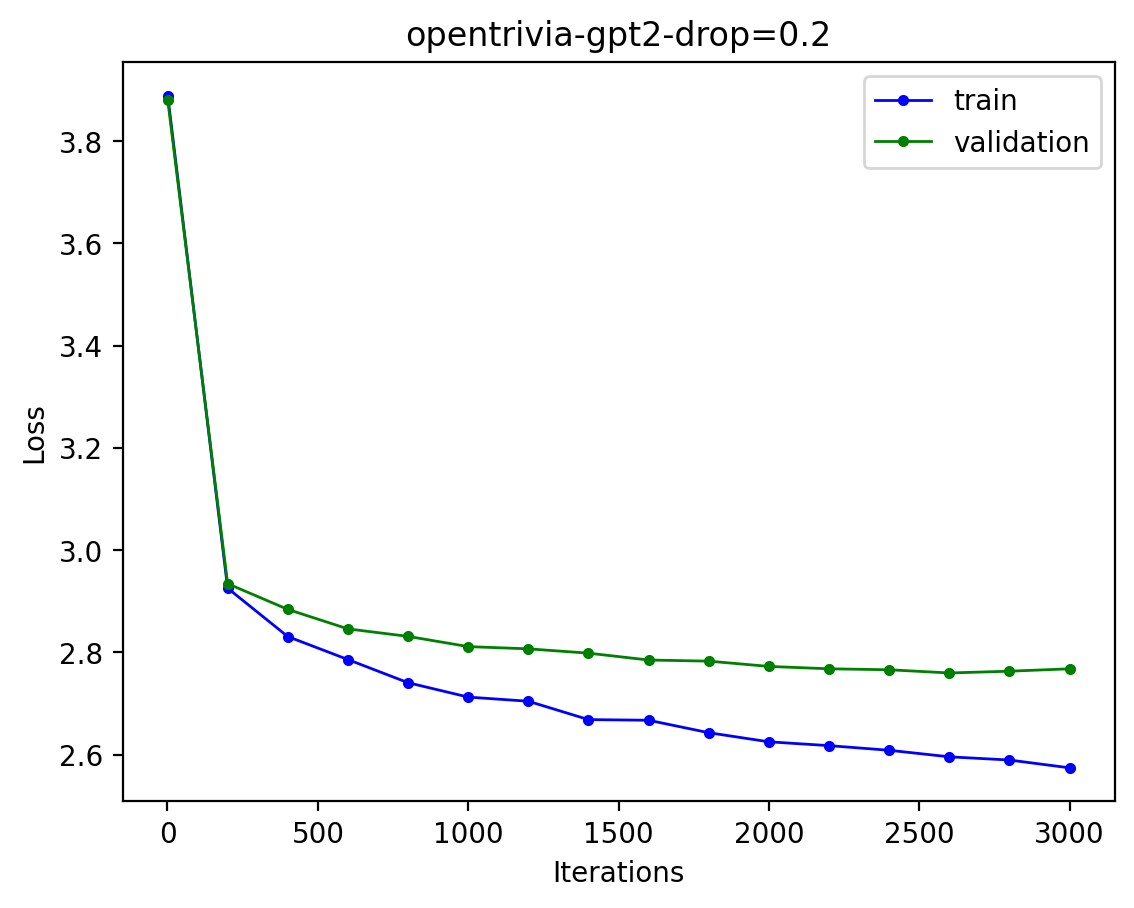

In [3]:
ben.plot_loss()

The train-validation loss gap is similar to the smaller dropout model and will only probably get wider.

It's early, as it only trained on very few data, but let's see some samplings:

In [4]:
ben.sample("Q: Why is the sky blue?\nA:", top=0.2, count=5)

Q: Why is the sky blue?
A: Because of the suns light.
--------------------------------------------------------------------------------
Q: Why is the sky blue?
A: Because of the light reflected by the Sun.
--------------------------------------------------------------------------------
Q: Why is the sky blue?
A: Because of the blue sky
--------------------------------------------------------------------------------
Q: Why is the sky blue?
A: Because of the blue sky
--------------------------------------------------------------------------------
Q: Why is the sky blue?
A: Because of the color of the sky


In [7]:
ben.sample("Q: What state of matter is ice in?\nA:", top=0.2, count=5)

Q: What state of matter is ice in?
A: Ice
--------------------------------------------------------------------------------
Q: What state of matter is ice in?
A: Ice
--------------------------------------------------------------------------------
Q: What state of matter is ice in?
A: Ice
--------------------------------------------------------------------------------
Q: What state of matter is ice in?
A: Ice
--------------------------------------------------------------------------------
Q: What state of matter is ice in?
A: Antarctic


In [9]:
ben.sample("Q: What is the capital of Portugal?\nA:", top=0.2, count=5)

Q: What is the capital of Portugal?
A: Lisbon
--------------------------------------------------------------------------------
Q: What is the capital of Portugal?
A: Lisbon
--------------------------------------------------------------------------------
Q: What is the capital of Portugal?
A: Lisbon
--------------------------------------------------------------------------------
Q: What is the capital of Portugal?
A: Lisbon
--------------------------------------------------------------------------------
Q: What is the capital of Portugal?
A: Lisbon


In [8]:
ben.sample("The")

The on-going struggle between sports hero and villain will likely be far different in it than one dealt with in Game 7 of the NBA Finals. In the NBA, the Finals will take place at Shea Stadium in New York.
A: True